In [3]:
# Import all required libraries at the beginning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set style for plots
plt.style.use('fivethirtyeight')

In [4]:
# Load the data
train_data = pd.read_csv('train.csv')
stores_data = pd.read_csv('stores.csv')
features_data = pd.read_csv('features.csv')

# Display basic information about the datasets
print("Train Data Shape:", train_data.shape)
print("Stores Data Shape:", stores_data.shape)
print("Features Data Shape:", features_data.shape)

print("\nFirst few rows of Train Data:")
print(train_data.head())

print("\nFirst few rows of Stores Data:")
print(stores_data.head())

print("\nFirst few rows of Features Data:")
print(features_data.head())

Train Data Shape: (421570, 5)
Stores Data Shape: (45, 3)
Features Data Shape: (8190, 12)

First few rows of Train Data:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

First few rows of Stores Data:
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

First few rows of Features Data:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-

In [5]:
# Merge datasets
print("Merging datasets...")

merged_data = pd.merge(train_data, features_data, on=['Store', 'Date'], how='left')
merged_data = pd.merge(merged_data, stores_data, on=['Store'], how='left')

merged_data['Date'] = pd.to_datetime(merged_data['Date'])

print("\nMissing values in merged dataset:")
print(merged_data.isnull().sum())

print("\nMerged dataset shape:", merged_data.shape)
print("\nFirst few rows of merged dataset:")
print(merged_data.head())

Merging datasets...

Missing values in merged dataset:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

Merged dataset shape: (421570, 17)

First few rows of merged dataset:
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50

In [6]:
# Handle missing values
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in merged_data.columns:
        merged_data[col].fillna(0, inplace=True)


if 'CPI' in merged_data.columns:
    merged_data['CPI'].fillna(method='ffill', inplace=True)
    merged_data['CPI'].fillna(method='bfill', inplace=True)

if 'Unemployment' in merged_data.columns:
    merged_data['Unemployment'].fillna(method='ffill', inplace=True)
    merged_data['Unemployment'].fillna(method='bfill', inplace=True)

print("\nMissing values: ")
print(merged_data.isnull().sum())

merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Week'] = merged_data['Date'].dt.isocalendar().week
merged_data['Day'] = merged_data['Date'].dt.day

if 'IsHoliday' in merged_data.columns:
    merged_data['IsHoliday'] = merged_data['IsHoliday'].astype(int)
else:
    merged_data['IsHoliday'] = 0
    #IsHoliday column created with default value 0

print("\nDataset after preprocessing:")
print(merged_data.head())
print("\nColumns available:", merged_data.columns.tolist())


Missing values: 
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64

Dataset after preprocessing:
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...         CPI  Unemployment  \
0        0.0        0.0        0.0  ...  211.096358         8.106   
1       

Exploratory Data Analysis...


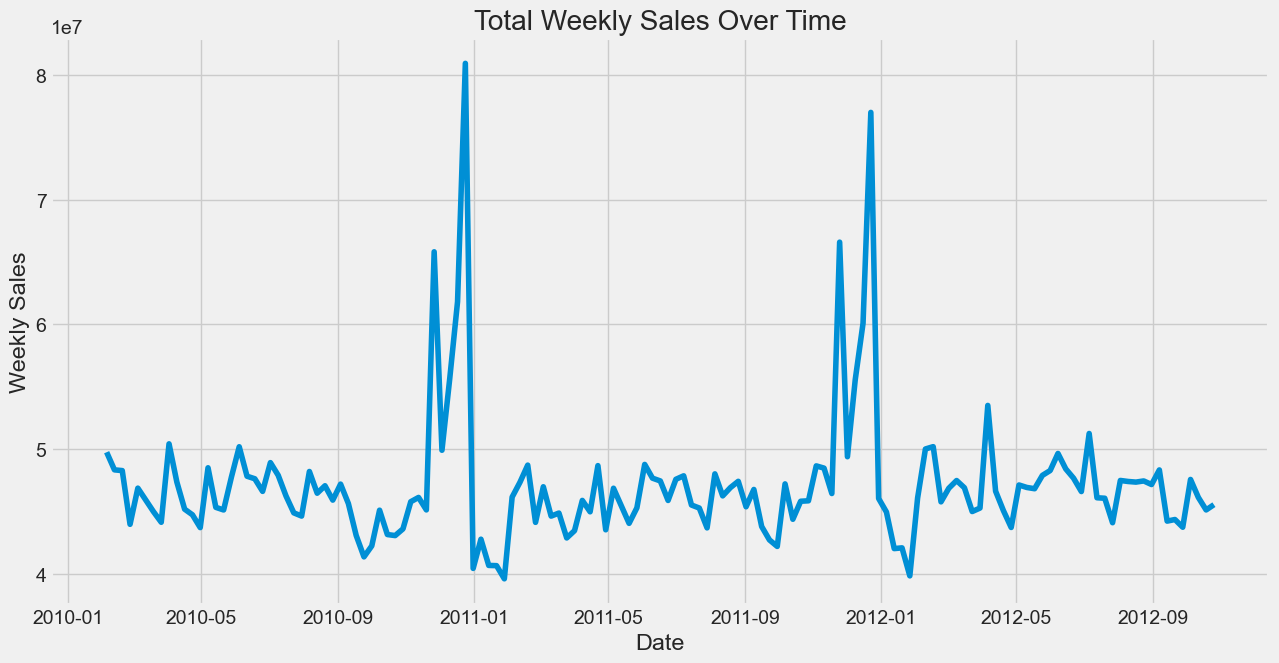

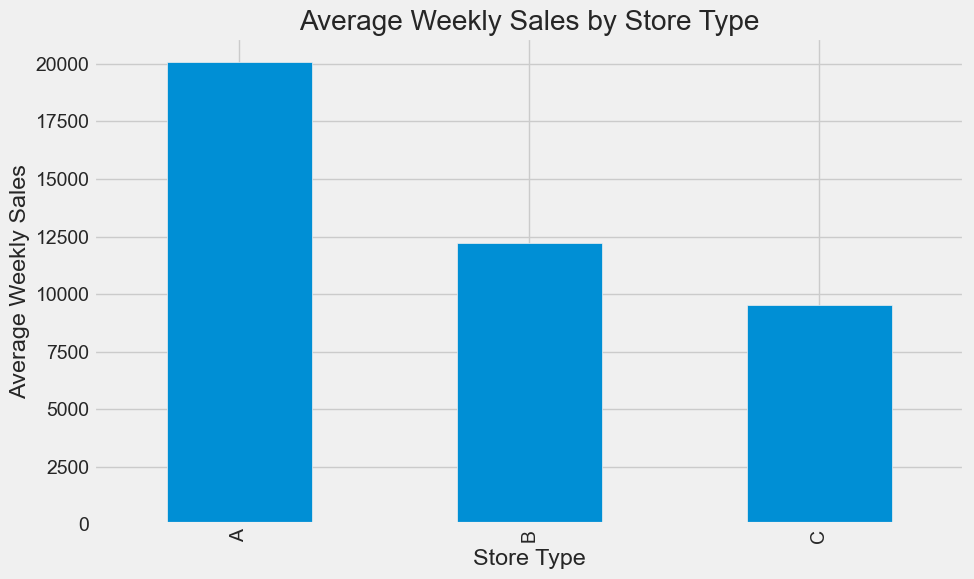

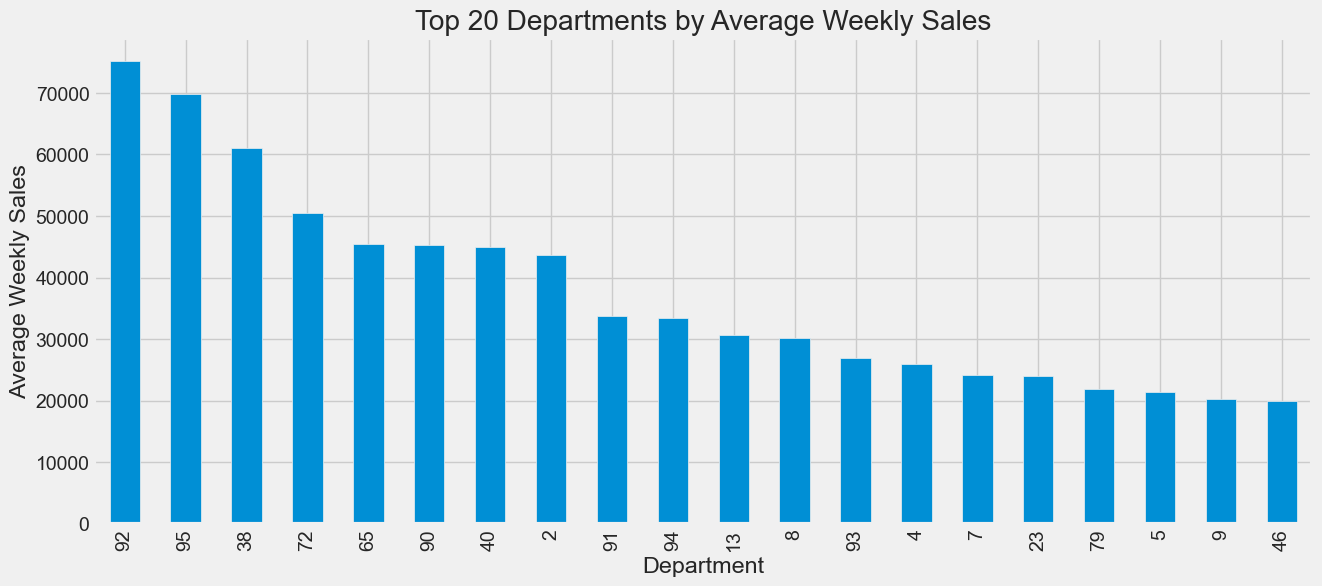

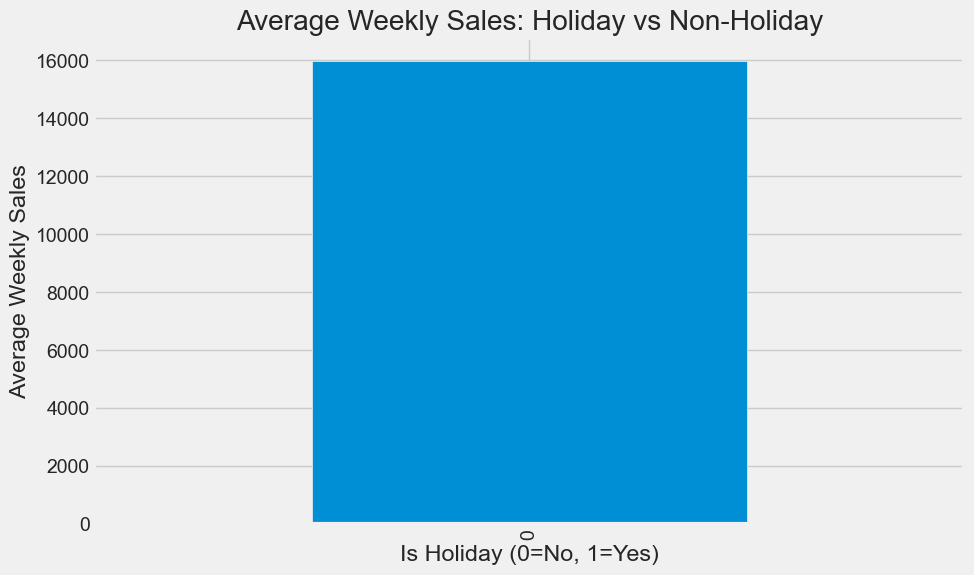

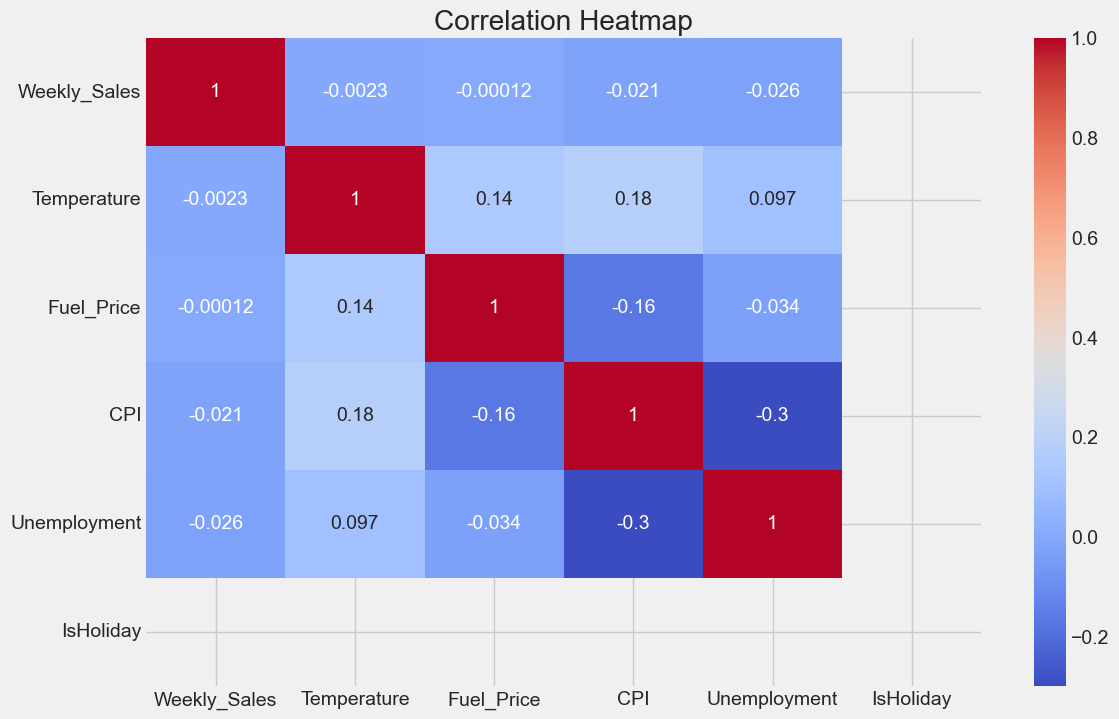

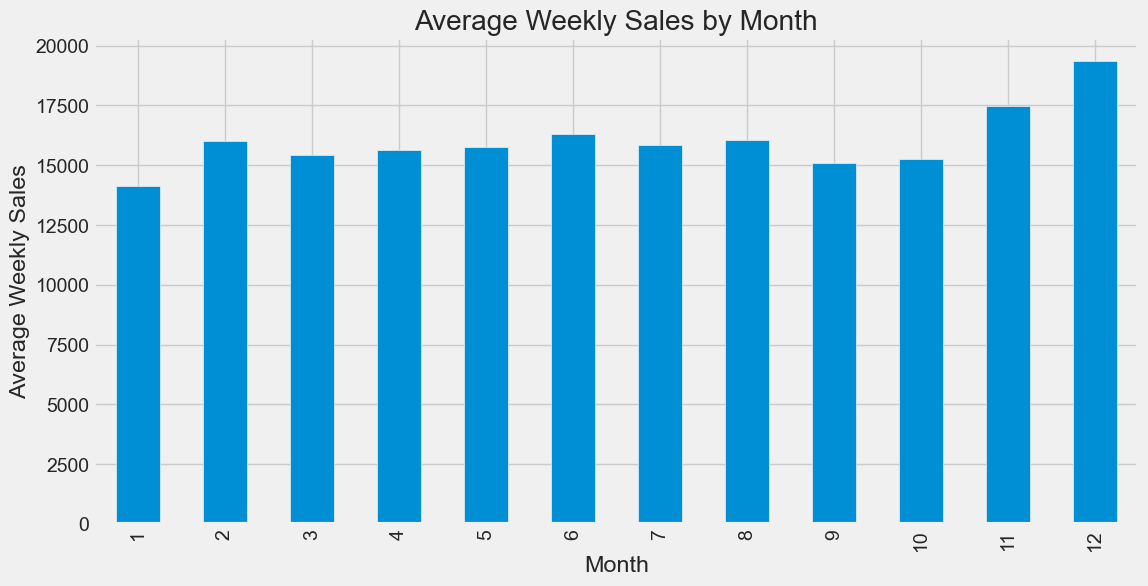

In [7]:
print("Exploratory Data Analysis...")

# Overall sales trend
plt.figure(figsize=(14, 7))
weekly_sales = merged_data.groupby('Date')['Weekly_Sales'].sum()
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

# Sales by store type
plt.figure(figsize=(10, 6))
store_type_sales = merged_data.groupby('Type')['Weekly_Sales'].mean()
store_type_sales.plot(kind='bar')
plt.title('Average Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Weekly Sales')
plt.show()

# Sales by department
plt.figure(figsize=(14, 6))
dept_sales = merged_data.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)
dept_sales.head(20).plot(kind='bar')
plt.title('Top 20 Departments by Average Weekly Sales')
plt.xlabel('Department')
plt.ylabel('Average Weekly Sales')
plt.show()

# Holiday impact on sales
plt.figure(figsize=(10, 6))
holiday_sales = merged_data.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_sales.plot(kind='bar')
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday (0=No, 1=Yes)')
plt.ylabel('Average Weekly Sales')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
correlation_matrix = merged_data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Sales distribution by month
plt.figure(figsize=(12, 6))
monthly_sales = merged_data.groupby('Month')['Weekly_Sales'].mean()
monthly_sales.plot(kind='bar')
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.show()